In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from prophet import Prophet

#Loading the data
temp_url = 'https://raw.githubusercontent.com/datasets/global-temp/master/data/monthly.csv'
co2_url = 'https://raw.githubusercontent.com/datasets/co2-fossil-global/master/global.csv'
sea_url = 'https://datahub.io/core/sea-level-rise/r/epa-sea-level.csv'
sst_url = 'https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v6/access/timeseries/aravg.ann.land_ocean.90S.90N.v6.0.0.202504.asc'

temp_df = pd.read_csv(temp_url)
co2_df = pd.read_csv(co2_url)
sea_df = pd.read_csv(sea_url)
sst_df = pd.read_fwf(sst_url, header=None, skiprows=4, usecols=[0, 1], names=['Year', 'SST'])


In [2]:
#Preprocess the data & merge them
temp_annual = temp_df[['Year', 'Mean']].rename(columns={'Mean': 'TempAnomaly'})
temp_annual['Year'] = temp_annual['Year'].str.split('-').str[0].astype(int)

co2_df['Year'] = co2_df['Year'].astype(int)

sea_df['Year'] = sea_df['Year'].astype(int)

sst_annual = sst_df.groupby('Year')['SST'].mean().reset_index()
sst_annual['Year'] = pd.to_numeric(sst_annual['Year'], errors='coerce')
sst_annual.dropna(subset=['Year'], inplace=True)
sst_annual['Year'] = sst_annual['Year'].astype(int)

df = temp_annual.merge(co2_df, on='Year').merge(sea_df, on='Year').merge(sst_annual, on='Year')
df = df[df['Year'] >= 1955].reset_index(drop=True)

df_yearly = df.groupby('Year').agg({'TempAnomaly': 'mean', 'Total': 'mean', 'SST': 'mean'}).reset_index()

df_yearly['Year_Squared'] = df_yearly['Year'] ** 2
df_yearly['Total_lag1'] = df_yearly['Total'].shift(1)
df_yearly['SST_lag1'] = df_yearly['SST'].shift(1)
df_yearly['Delta_Total'] = df_yearly['Total'] - df_yearly['Total_lag1']
df_yearly['Delta_SST'] = df_yearly['SST'] - df_yearly['SST_lag1']
df_yearly['SST_roll3'] = df_yearly['SST'].rolling(3).mean()

df_yearly.dropna(inplace=True)
df_yearly.head()


,Year,TempAnomaly,Total,SST,Year_Squared,Total_lag1,SST_lag1,Delta_Total,Delta_SST,SST_roll3
2,1957,0.006500,2270.0,-0.247771,3829849,2177.0,-0.470839,93.0,0.223068,-0.383375
3,1958,0.022017,2330.0,-0.213801,3833764,2270.0,-0.247771,60.0,0.033970,-0.310804
4,1959,-0.008571,2454.0,-0.230777,3837681,2330.0,-0.213801,124.0,-0.016976,-0.230783
5,1960,-0.070229,2569.0,-0.301876,3841600,2454.0,-0.230777,115.0,-0.071099,-0.248818
6,1961,0.018750,2580.0,-0.230654,3845521,2569.0,-0.301876,11.0,0.071222,-0.254436


In [ ]:
#Select the model & train model
features = ['Year', 'Year_Squared', 'Total','Total_lag1', 'Delta_Total', 'Delta_SST', 'SST_lag1']
X = df_yearly[features]
y = df_yearly['TempAnomaly']

model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\nModel Performance:")
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")



Model Performance:
R² Score: 0.927
RMSE: 0.085
MAE: 0.067


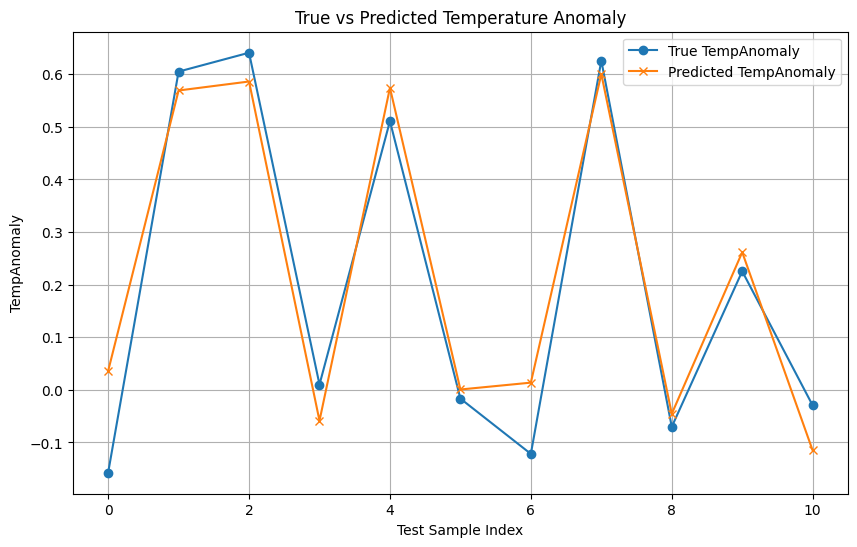

In [ ]:
#Compare the values: True vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='True TempAnomaly', marker='o')
plt.plot(y_pred, label='Predicted TempAnomaly', marker='x')
plt.title('True vs Predicted Temperature Anomaly')
plt.xlabel('Test Sample Index')
plt.ylabel('TempAnomaly')
plt.legend()
plt.grid(True)
plt.show()


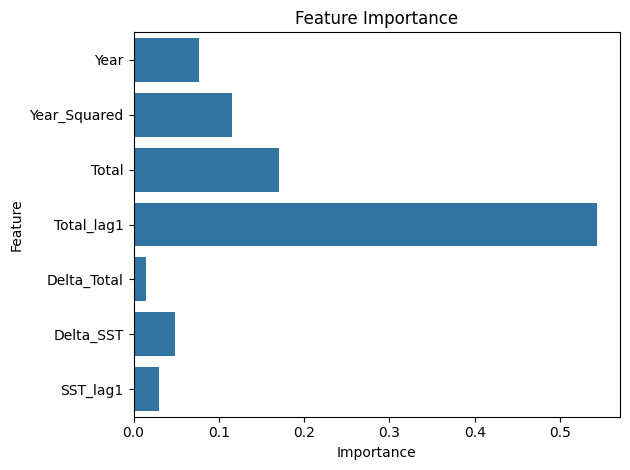

In [ ]:
#Important feature
importances = model.feature_importances_
sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb0qte_y5/8q_numts.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb0qte_y5/lv9ypd42.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4414', 'data', 'file=/tmp/tmpb0qte_y5/8q_numts.json', 'init=/tmp/tmpb0qte_y5/lv9ypd42.json', 'output', 'file=/tmp/tmpb0qte_y5/prophet_modelkihgdy18/prophet_model-20250526064825.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:48:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:48:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


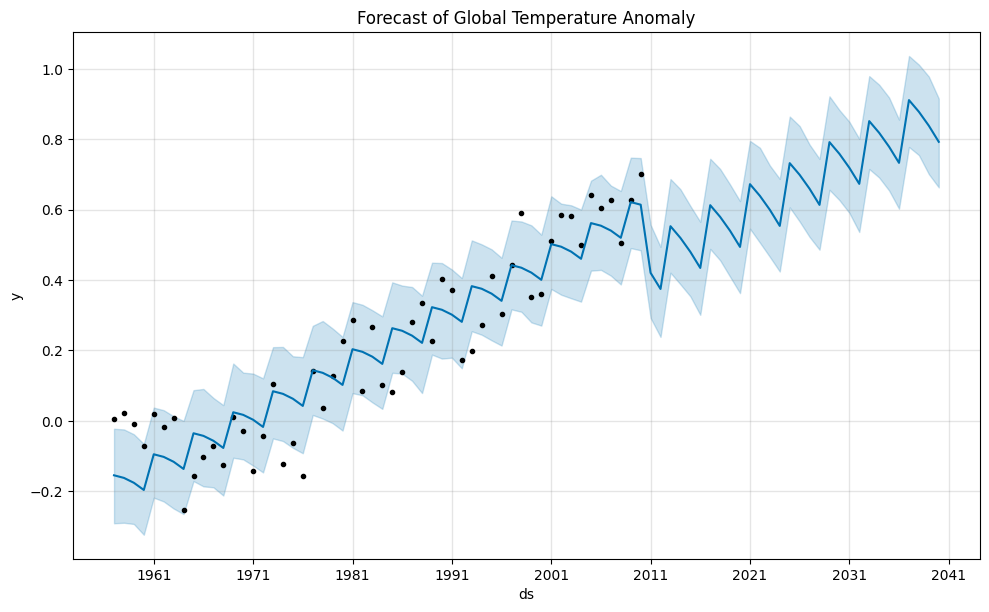

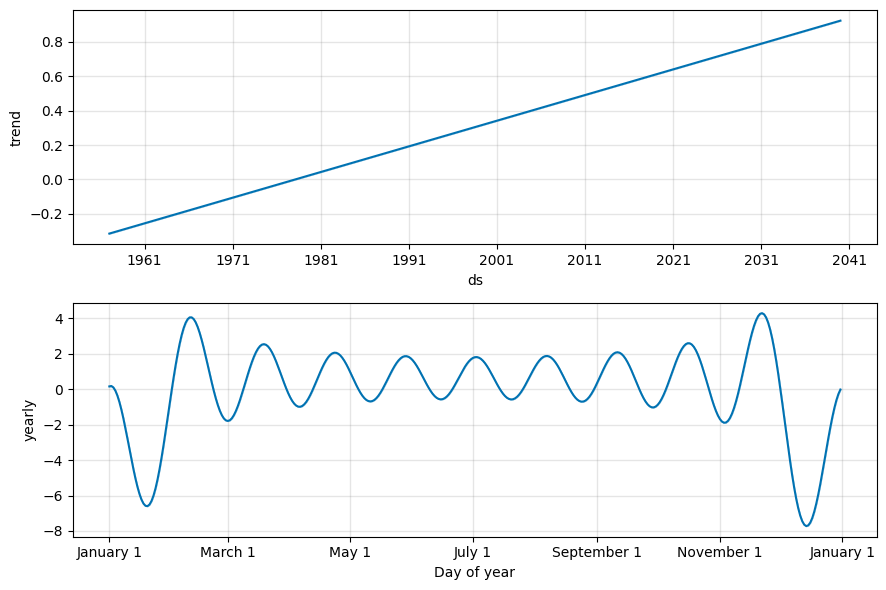

In [ ]:
#Forecasting using Prophet
df_prophet = df_yearly[['Year', 'TempAnomaly']].copy()
df_prophet = df_prophet.rename(columns={'Year': 'ds', 'TempAnomaly': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')

model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=30, freq='Y')
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
plt.title("Forecast of Global Temperature Anomaly")
plt.show()

# Plot forecast components
fig2 = model.plot_components(forecast)
plt.show()